/tmp/ipykernel_54888/1661118184.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")



=== PESQ Statistics by Location (Merged Caller+Callee) ===
                 Location  Samples % > 3.0 Avg PESQ  Min  Max
     Bangalore - New York     5766   21.35     2.47 0.00 4.49
        Cape Town - Seoul     2982    5.94     1.71 0.00 4.43
       Frankfurt - London     5992   25.25     2.53 0.00 4.42
         Jakarta - Mexico     3618   22.31     2.47 0.00 4.46
        New York - Sydney     2992   14.94     2.26 0.00 4.46
      Oregon - California     2400    4.42     1.60 0.00 4.45
              Osaka - UAE     2998   11.31     2.57 1.11 3.96
           Paris - London     2790    5.38     1.65 0.00 4.33
San Francisco - Amsterdam     6076   18.22     2.57 0.00 4.49
     Singapore - New York     5376   12.17     2.34 0.00 4.46
    Stockholm - Frankfurt     2208    3.80     1.59 0.00 4.31
       Sydney - Frankfurt     6068   15.41     2.45 0.00 4.47
     São Paulo - Malaysia     2692   29.23     2.61 0.00 4.44
        Tel Aviv - Sydney     4084    4.46     2.25 0.00 3.37
          

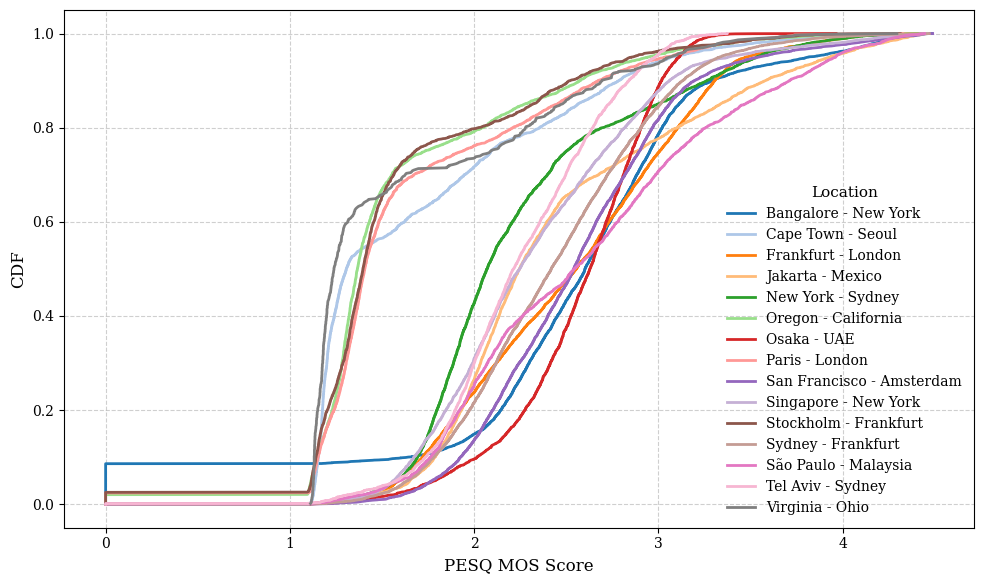


=== Codec-wise Number of Calls per Location ===
codec                       g711   gsm  opus  speex  TOTAL
São Paulo - Malaysia         499   347   500      0   1346
Tel Aviv - Sydney            546   500   496    500   2042
Frankfurt - London          1498   500   498    500   2996
Sydney - Frankfurt          1537   499   499    499   3034
Bangalore - New York        1389   498   497    499   2883
Singapore - New York        1194   499   496    499   2688
San Francisco - Amsterdam   1543   499   500    496   3038
New York - Sydney              0   499   500    497   1496
Cape Town - Seoul            497   500   494      0   1491
Jakarta - Mexico             310   500   499    500   1809
Osaka - UAE                  500   499   500      0   1499
Oregon - California          200   400   400    200   1200
Paris - London               200   399   399    397   1395
Stockholm - Frankfurt        104   400   400    200   1104
Virginia - Ohio               50     0    50    198    298
TOTAL  

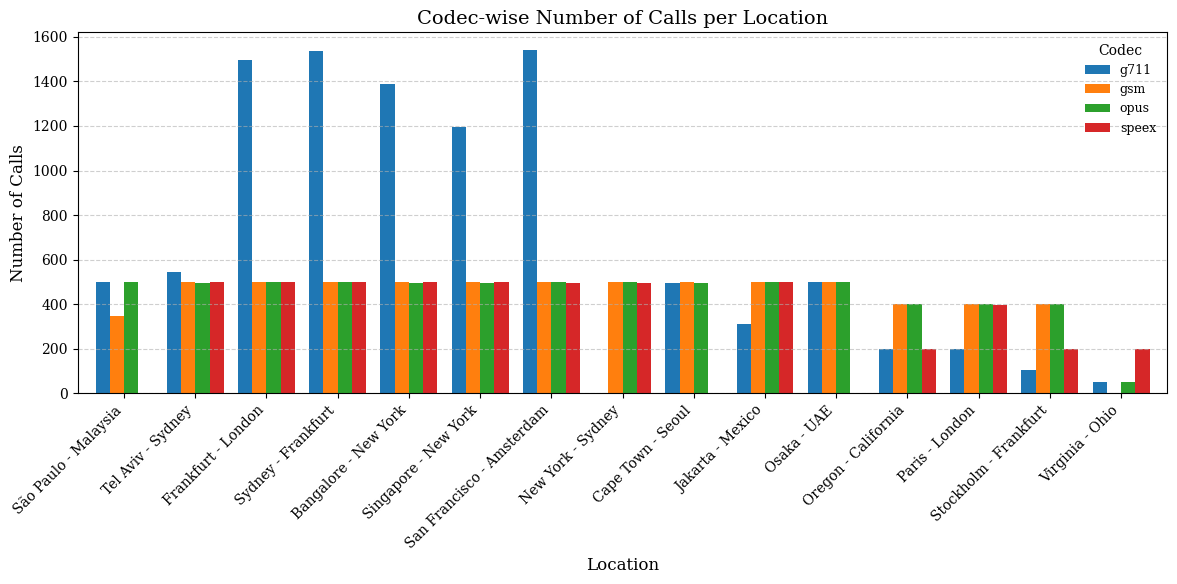

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import get_cmap

# === CONFIGURE FOR ACADEMIC QUALITY PLOTS ===
rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "pdf.fonttype": 42,  # Editable fonts
})

# === Read CSV ===
data_file = "../../data/final-tor.csv"
df = pd.read_csv(data_file)
df = df.dropna(subset=["caller_pesq_mos", "callee_pesq_mos"])

# === Location label map ===
label_map = {
    "1Frank-Lond":          "Frankfurt - London",
    "2sydney-frank":        "Sydney - Frankfurt",
    "3Bangl-nyc":           "Bangalore - New York",
    "4singapore-nyc":       "Singapore - New York",
    "5sans-amster":         "San Francisco - Amsterdam",
    "6nyc-syd":             "New York - Sydney",
    "7CapeTown-Seoul":      "Cape Town - Seoul",
    "8Jakarta-Mexico":      "Jakarta - Mexico",
    "9Osaka-UAE":           "Osaka - UAE",
    "10SauPaul-malaysia":   "São Paulo - Malaysia",
    "11TelAviv-Sydney3":    "Tel Aviv - Sydney",
    "Oregon-California":    "Oregon - California",
    "Paris-London":         "Paris - London",
    "Stockholm-Frankfurt":  "Stockholm - Frankfurt",
    "Virginia-Ohio":        "Virginia - Ohio",
}

# Keep only locations in map
df = df[df["location"].isin(label_map.keys())].copy()

# =========================
# 1) PESQ CDF (LOCATION-ONLY, CLEAN LEGEND)
# =========================
locations = sorted(df["location"].unique(), key=lambda x: label_map.get(x, x))
cmap = get_cmap("tab20")
colors = [cmap(i % cmap.N) for i in range(len(locations))]

plt.figure(figsize=(10, 6))
df_grouped = df.groupby("location")

# Collect stats for table
stats_rows = []

for i, loc in enumerate(locations):
    g = df_grouped.get_group(loc)
    merged = np.sort(np.concatenate([g["caller_pesq_mos"].values, g["callee_pesq_mos"].values]))
    cdf = np.arange(1, len(merged) + 1) / len(merged)

    loc_name = label_map.get(loc, loc)
    plt.plot(merged, cdf, label=loc_name, linewidth=2, color=colors[i])

    pct_gt3 = (np.sum(merged > 3.0) / len(merged)) * 100 if len(merged) else 0.0
    stats_rows.append({
        "Location": loc_name,
        "Samples": int(len(merged)),
        "% > 3.0": f"{pct_gt3:.2f}",
        "Avg PESQ": f"{np.mean(merged):.2f}",
        "Min": f"{np.min(merged):.2f}",
        "Max": f"{np.max(merged):.2f}",
    })

# Add TOTAL row for PESQ stats
all_values = np.sort(np.concatenate([
    np.sort(np.concatenate([df_grouped.get_group(loc)["caller_pesq_mos"].values,
                            df_grouped.get_group(loc)["callee_pesq_mos"].values]))
    for loc in locations
]))
total_row = {
    "Location": "TOTAL",
    "Samples": int(len(all_values)),
    "% > 3.0": f"{(np.sum(all_values > 3.0) / len(all_values)) * 100:.2f}",
    "Avg PESQ": f"{np.mean(all_values):.2f}",
    "Min": f"{np.min(all_values):.2f}",
    "Max": f"{np.max(all_values):.2f}",
}
stats_rows.append(total_row)

stats_df = pd.DataFrame(stats_rows)
print("\n=== PESQ Statistics by Location (Merged Caller+Callee) ===")
print(stats_df.to_string(index=False))
stats_df.to_csv("pesq_stats_by_location.csv", index=False)

plt.xlabel("PESQ MOS Score", fontsize=12)
plt.ylabel("CDF", fontsize=12)
plt.legend(loc="lower right", frameon=False, title="Location", title_fontsize=11)
plt.grid(True, linestyle="--", linewidth=0.8, alpha=0.6)
plt.tight_layout()
plt.savefig("merged_pesq_cdf_location_wise.pdf", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

# ==========================================
# 2) CODEC-WISE COUNTS TABLE (NO EFFECT ON CDF)
# ==========================================
codec_counts = (
    df.groupby(["location", "codec"])
      .size()
      .reset_index(name="num_calls")
)

codec_table = (
    codec_counts
    .pivot(index="location", columns="codec", values="num_calls")
    .fillna(0)
    .astype(int)
    .sort_index()
)

# Add TOTAL row/col
codec_table.loc["TOTAL"] = codec_table.sum(axis=0)
codec_table["TOTAL"] = codec_table.sum(axis=1)

# Replace index with pretty names (keep TOTAL)
codec_table.index = [label_map.get(idx, idx) if idx != "TOTAL" else "TOTAL"
                     for idx in codec_table.index]

print("\n=== Codec-wise Number of Calls per Location ===")
print(codec_table.to_string())
codec_table.to_csv("codec_counts_by_location.csv")

# Optional: grouped bar chart for codec counts
codec_table_plot = codec_table.drop("TOTAL", axis=0).drop(columns=["TOTAL"], errors="ignore")
ax = codec_table_plot.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.xlabel("Location", fontsize=12)
plt.ylabel("Number of Calls", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.title("Codec-wise Number of Calls per Location", fontsize=14)
plt.legend(title="Codec", fontsize=9, title_fontsize=10, frameon=False)
plt.grid(axis="y", linestyle="--", linewidth=0.8, alpha=0.6)
plt.tight_layout()
plt.savefig("codec_counts_by_location.pdf", dpi=300, bbox_inches="tight", transparent=True)
plt.show()
